In [1]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer, losses, InputExample
from torch.utils.data import DataLoader
import umap
import matplotlib.pyplot as plt

2023-11-29 17:26:22.624903: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 17:26:22.677810: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# 데이터 로드
in_domain = pd.read_csv('indomain_food.csv')  # in_domain 데이터
ood = pd.read_csv('ood_cloth.csv')  # out_of_domain 데이터

/tmp/ipykernel_71571/899332130.py:2: DtypeWarning: Columns (1,2,3,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  in_domain = pd.read_csv('indomain_food.csv')  # in_domain 데이터
/tmp/ipykernel_71571/899332130.py:3: DtypeWarning: Columns (1,2,3,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  ood = pd.read_csv('ood_cloth.csv')  # out_of_domain 데이터


In [13]:
in_domain = in_domain.iloc[:100000]
ood = ood.iloc[:100000]

In [14]:
# SBERT 모델 로드
model = SentenceTransformer('all-MiniLM-L6-v2')

In [15]:
# DataLoader 생성
train_examples = [InputExample(texts=[anchor, positive, negative]) for anchor, positive, negative in zip(in_domain['카테고리'], in_domain['카테고리'], ood['카테고리'])]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [16]:
# TripletLoss 정의 및 모델 학습
train_loss = losses.TripletLoss(model=model)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/6250 [00:00<?, ?it/s]

In [17]:
# 임베딩 생성 및 UMAP으로 2차원으로 축소
in_domain_embeddings = model.encode(in_domain['발화문'].tolist())
ood_embeddings = model.encode(ood['발화문'].tolist())

reducer = umap.UMAP()
in_domain_embeddings_2d = reducer.fit_transform(in_domain_embeddings)
ood_embeddings_2d = reducer.fit_transform(ood_embeddings)

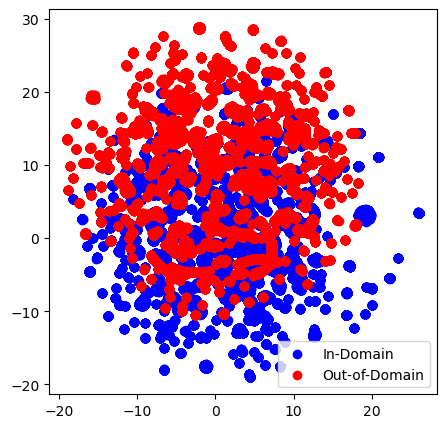

In [18]:
# 시각화
plt.figure(figsize=(5, 5))
plt.scatter(in_domain_embeddings_2d[:, 0], in_domain_embeddings_2d[:, 1], color='blue', label='In-Domain')
plt.scatter(ood_embeddings_2d[:, 0], ood_embeddings_2d[:, 1], color='red', label='Out-of-Domain')
plt.legend()
plt.show()